# Lab 5. TensorFlow and Convolutional Neural Network

In [1]:
from tqdm.keras import TqdmCallback
from tqdm import tqdm_notebook
from livelossplot import PlotLossesKeras
from keras.optimizers import SGD
from keras.utils import plot_model
import keras
from IPython.display import Image

In [2]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D, Input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os
import numpy as np
import matplotlib.pyplot as plt
import visualkeras as vk
from PIL import Image
CPU_ONLY = False

In [3]:
if CPU_ONLY: os.environ['CUDA_VISIBLE_DEVICES'] = '-1'
print(f"TensorFlow version: {tf.__version__}")
print("CUDA version:")
print(os.popen('nvcc --version').read())
with_cuda = tf.test.is_built_with_cuda()
print(f"Can build with CUDA: {with_cuda}")
gpus = tf.config.experimental.list_physical_devices('GPU')
# for gpu in gpus: tf.config.experimental.set_memory_growth(gpu, True)
print("Num GPUs Available: ", len(gpus))
for x in gpus: print(x)

TensorFlow version: 2.3.1
CUDA version:
nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2019 NVIDIA Corporation
Built on Fri_Feb__8_19:08:26_Pacific_Standard_Time_2019
Cuda compilation tools, release 10.1, V10.1.105

Can build with CUDA: True
Num GPUs Available:  1
PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


In [4]:
_URL = 'https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip'
path_to_zip = tf.keras.utils.get_file('cats_and_dogs.zip', origin=_URL, extract=True)
PATH = os.path.join(os.path.dirname(path_to_zip), 'cats_and_dogs_filtered')

In [5]:
train_dir = os.path.join(PATH, 'train')
validation_dir = os.path.join(PATH, 'validation')
train_cats_dir = os.path.join(train_dir, 'cats')
train_dogs_dir = os.path.join(train_dir, 'dogs')
validation_cats_dir = os.path.join(validation_dir, 'cats')
validation_dogs_dir = os.path.join(validation_dir, 'dogs')

In [6]:
num_cats_tr = len(os.listdir(train_cats_dir))
num_dogs_tr = len(os.listdir(train_dogs_dir))
num_cats_val = len(os.listdir(validation_cats_dir))
num_dogs_val = len(os.listdir(validation_dogs_dir))
total_train = num_cats_tr + num_dogs_tr
total_val = num_cats_val + num_dogs_val

In [7]:
print('total training cat images:', num_cats_tr)
print('total training dog images:', num_dogs_tr)
print('total validation cat images:', num_cats_val)
print('total validation dog images:', num_dogs_val)
print("--")
print("Total training images:", total_train)
print("Total validation images:", total_val)

total training cat images: 1000
total training dog images: 1000
total validation cat images: 500
total validation dog images: 500
--
Total training images: 2000
Total validation images: 1000


In [8]:
batch_size = 128
epochs = 20
IMG_HEIGHT = 150
IMG_WIDTH = 150

In [9]:
train_image_generator = ImageDataGenerator(rescale=1./255)
validation_image_generator = ImageDataGenerator(rescale=1./255)

In [10]:
train_data_gen = train_image_generator.flow_from_directory(batch_size=batch_size,
directory=train_dir, shuffle=True, target_size=(IMG_HEIGHT, IMG_WIDTH),
class_mode='binary')

Found 2000 images belonging to 2 classes.


In [11]:
val_data_gen = validation_image_generator.flow_from_directory(batch_size=batch_size,
directory=validation_dir,target_size=(IMG_HEIGHT, IMG_WIDTH),class_mode='binary')

Found 1000 images belonging to 2 classes.


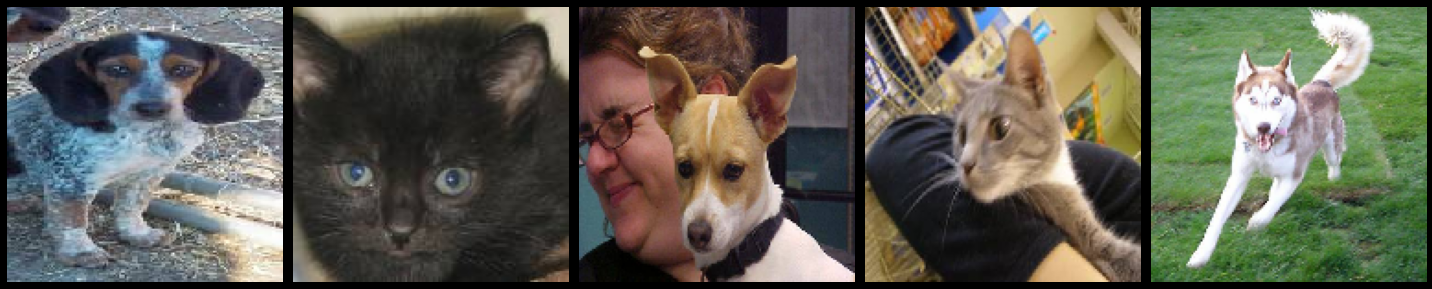

In [12]:
sample_training_images, _ = next(train_data_gen)
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()
plotImages(sample_training_images[:5])

In [13]:
model = Sequential([
    Conv2D(16, 3, padding='same', activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH ,3)),
    MaxPooling2D(),
    Conv2D(32, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Conv2D(64, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Flatten(),
    Dense(512, activation='relu'),
    Dense(1)
])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 150, 150, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 75, 75, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 75, 75, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 37, 37, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 37, 37, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 18, 18, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 20736)             0

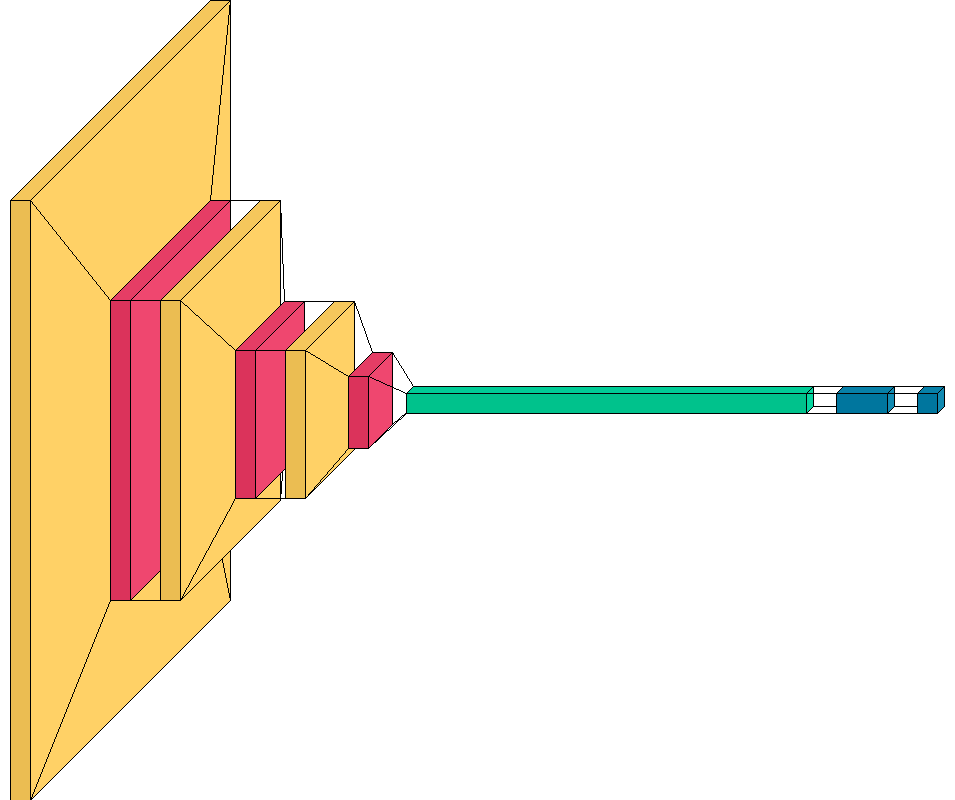

In [14]:
model.compile(optimizer='adam',
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=['accuracy'])
model.summary()
vk.layered_view(model, spacing=30)

In [15]:
pbar = TqdmCallback(verbose=1,tqdm_class=tqdm_notebook, leave = True, display = False)
pbar.epoch_bar.ncols=0
plot = PlotLossesKeras()

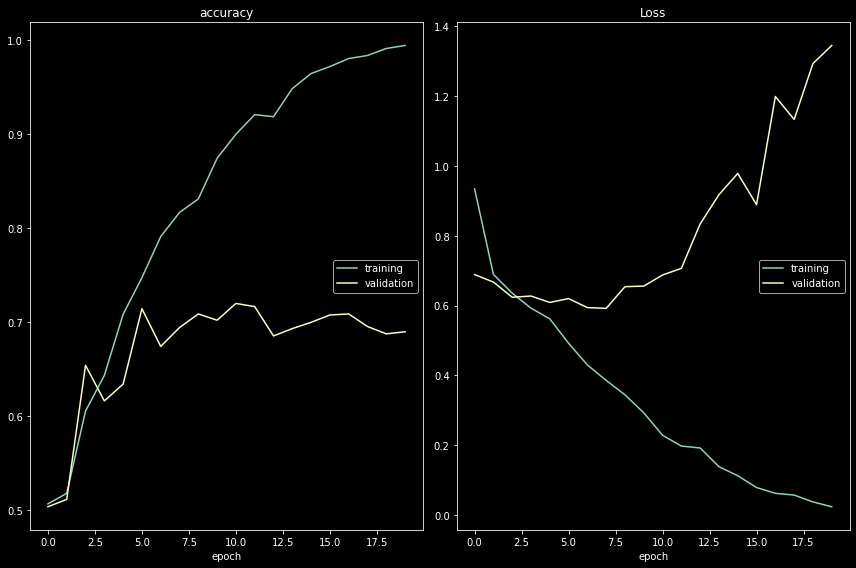

accuracy
	training         	 (min:    0.506, max:    0.995, cur:    0.995)
	validation       	 (min:    0.503, max:    0.720, cur:    0.690)
Loss
	training         	 (min:    0.024, max:    0.934, cur:    0.024)
	validation       	 (min:    0.592, max:    1.345, cur:    1.345)
Wall time: 1min 56s


In [16]:
%%time
pbar.display()
history = model.fit_generator(
    train_data_gen,
    steps_per_epoch=total_train // batch_size,
    epochs=epochs,
    verbose=0,
    validation_data=val_data_gen,
    validation_steps=total_val // batch_size,
    callbacks=[pbar,plot]
)

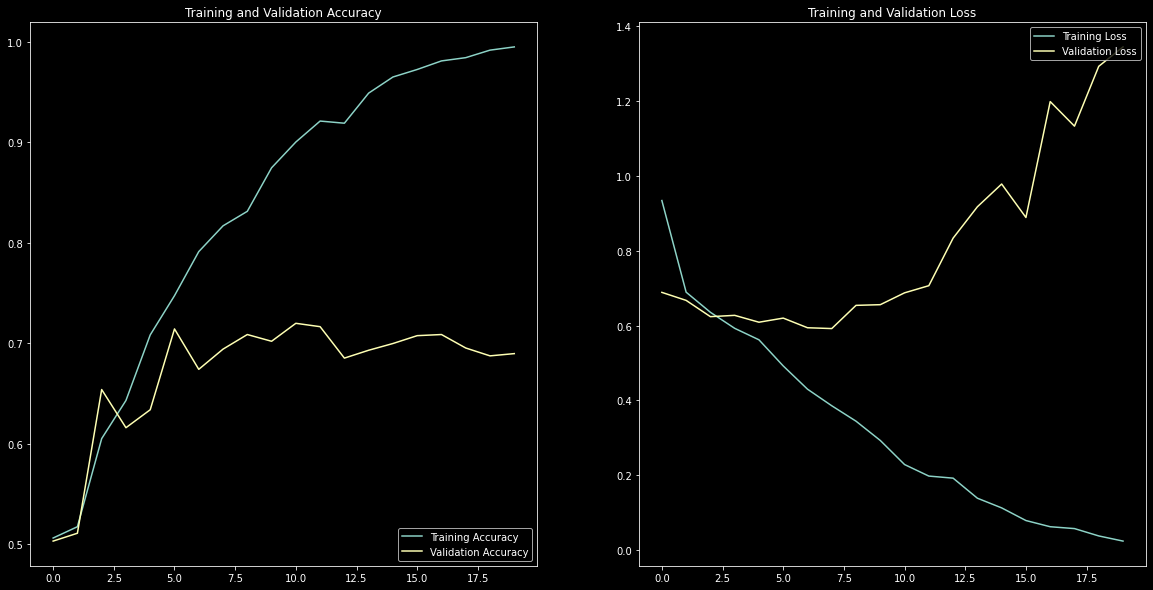

In [17]:
def plotResult(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss=history.history['loss']
    val_loss=history.history['val_loss']
    tla = []
    vla = []
    for i in range(len(acc)): 
        tla.append(acc[i]*loss[i])
        vla.append(val_acc[i]*val_loss[i])
    epochs_range = range(epochs)
    plt.figure(figsize=(20, 10))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()
plotResult(history)

## Q1. 

How would you describe the trend of (1) training accuracy, (2) validation accuracy, (3) training loss, and (4) validation loss?

- Training accuracy: Upward trending 
- Validation accuracy: Rise quickly then oscillates around 0.73
- Training loss: Downward trending 
- Validation loss: Decreased to around 0.6, follow with a rebound and is then gradually increasing

## Q2. 

Do you observe any issue in the plots, for example, overfitting?

The model is overfitting to the training data, whereas the accuracy for testing data is stagnant. Other than that, the gradually increasing validation loss indicates that the model is starting to "memorize" the training data. 

![](https://github.com/DMinghao/Deep_Learning_with_Unstructured_Data/blob/main/Labs/Lab_5/cute_puppy.jpg?raw=true)

In [18]:
image_gen_train = ImageDataGenerator(
    rescale=1./255,
    rotation_range=45,
    width_shift_range=.15,
    height_shift_range=.15,
    horizontal_flip=True,
    zoom_range=0.5
)
train_data_gen = image_gen_train.flow_from_directory(
    batch_size=batch_size,
    directory=train_dir, 
    shuffle=True,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    class_mode='binary')

Found 2000 images belonging to 2 classes.


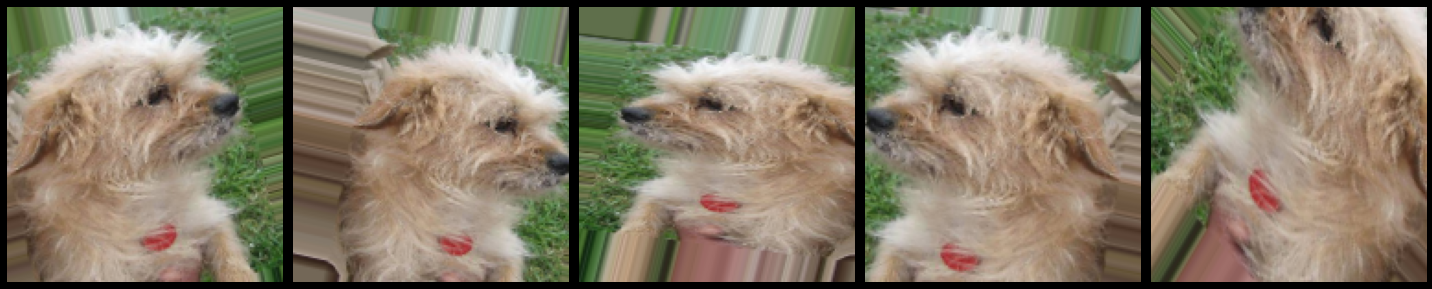

In [19]:
augmented_images = [train_data_gen[0][0][0] for i in range(5)]
plotImages(augmented_images)

In [20]:
image_gen_val = ImageDataGenerator(rescale=1./255)
val_data_gen = image_gen_val.flow_from_directory(
    batch_size=batch_size,
    directory=validation_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    class_mode='binary')

Found 1000 images belonging to 2 classes.


# Assignment 

In [21]:
modelImproved = Sequential([
    Conv2D(16, 3, padding='same', activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH ,3)),
    MaxPooling2D(),
    Dropout(0.2),
    Conv2D(32, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Conv2D(64, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Dropout(0.2),
    Flatten(),
    Dense(512, activation='relu'),
    Dense(1)
])

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 150, 150, 16)      448       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 75, 75, 16)        0         
_________________________________________________________________
dropout (Dropout)            (None, 75, 75, 16)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 75, 75, 32)        4640      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 37, 37, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 37, 37, 64)        18496     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 18, 18, 64)       

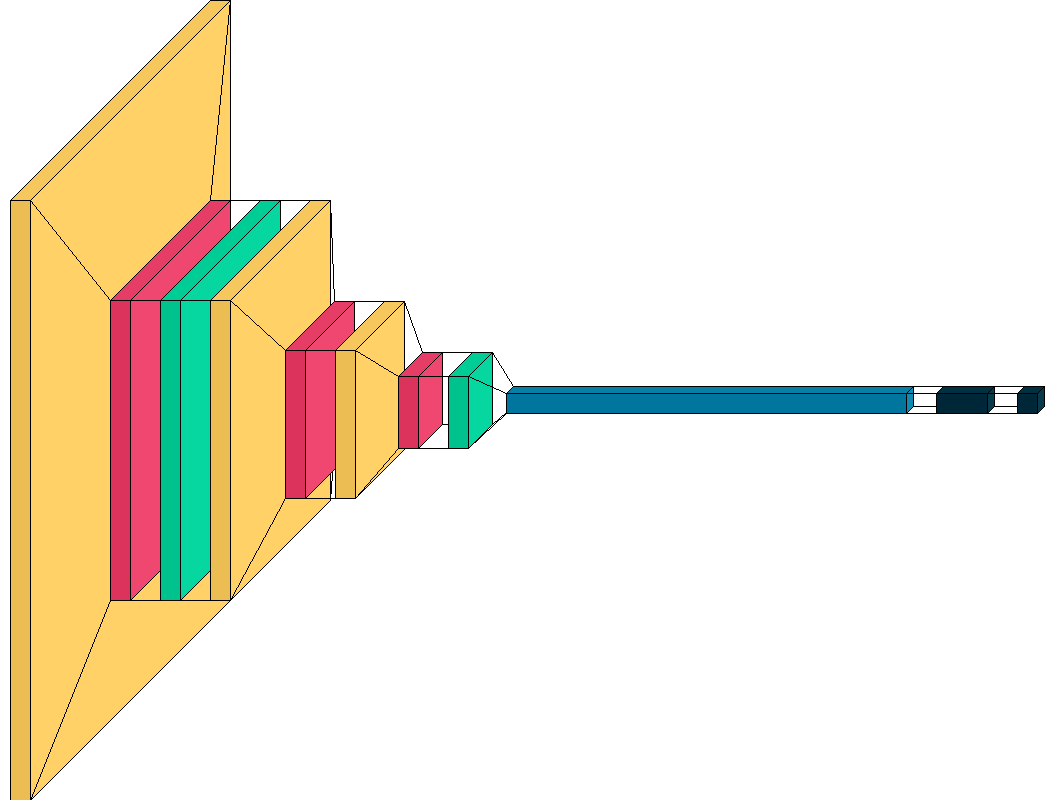

In [22]:
modelImproved.compile(optimizer='adam',
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=['accuracy'])
modelImproved.summary()
vk.layered_view(modelImproved, spacing=30)

In [23]:
pbar = TqdmCallback(verbose=1,tqdm_class=tqdm_notebook, leave = True, display = False)
pbar.epoch_bar.ncols=0
plot = PlotLossesKeras()
epochs = 150

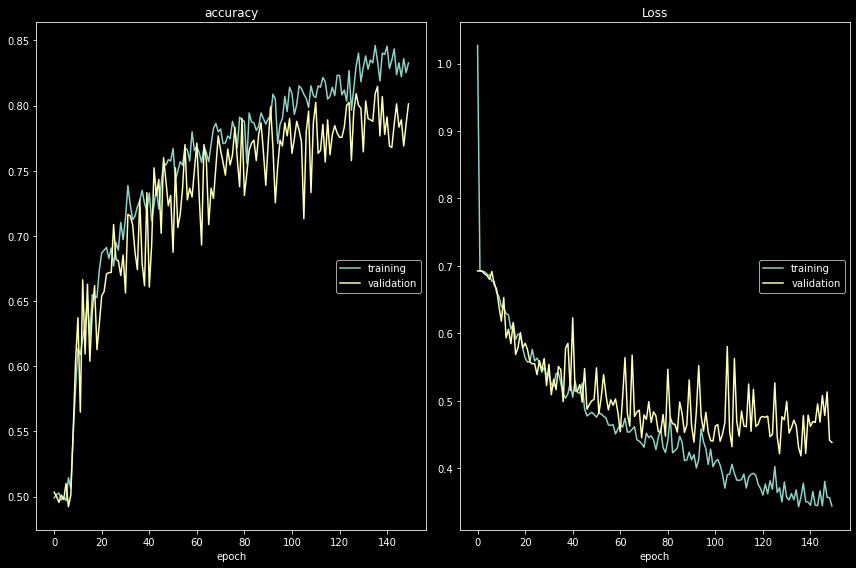

accuracy
	training         	 (min:    0.497, max:    0.846, cur:    0.833)
	validation       	 (min:    0.492, max:    0.815, cur:    0.801)
Loss
	training         	 (min:    0.343, max:    1.027, cur:    0.344)
	validation       	 (min:    0.419, max:    0.693, cur:    0.438)
Wall time: 33min 8s


In [24]:
%%time
pbar.display()
history = modelImproved.fit(
    train_data_gen,
    steps_per_epoch=total_train // batch_size,
    epochs=epochs,
    verbose=0,
    validation_data=val_data_gen,
    validation_steps=total_val // batch_size,
    callbacks=[pbar,plot]
)

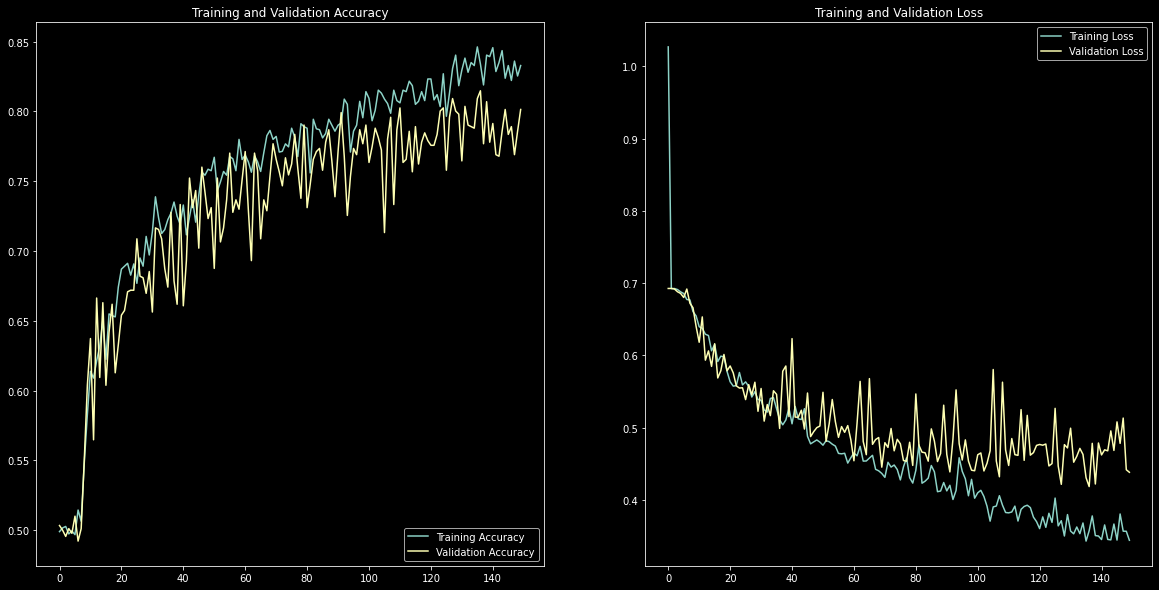

In [25]:
plotResult(history)

## Q3. 

How would you describe the trend of (1) training accuracy, (2) validation accuracy, (3) training loss, and (4) validation loss?

- Training accuracy: Upward trending 
- Validation accuracy: Rise along with training accuracy line, oscillates around 0.78
- Training loss: Downward trending 
- Validation loss: Decrease along with training loss line, oscillates around 0.5

## Q4. 

Do you think the issue before regularization is solved after regularization?

To some degrees, yes, the model is less overfitted after regularization. However, the validation accuracy and validation loss still shows that there could be more improvements.

![](https://github.com/DMinghao/Deep_Learning_with_Unstructured_Data/blob/main/Labs/Lab_5/cute_kitpy.jpg?raw=true)

# ARTIFICIAL STUPIDITY

In [26]:
epochs = 100
accuracy_threshold = 0.95
batch_size = 32

In [27]:
train_image_generator = ImageDataGenerator(
    rescale=1./255,
    rotation_range=45,
    width_shift_range=0.15,
    height_shift_range=0.15,
    shear_range=0.5,
    zoom_range=0.5,
    horizontal_flip=True,
    vertical_flip=True)

In [28]:
train_data_gen = train_image_generator.flow_from_directory(
    batch_size=batch_size,
    directory=train_dir, 
    shuffle=True, 
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    class_mode='binary')
val_data_gen = validation_image_generator.flow_from_directory(
    batch_size=batch_size,
    directory=validation_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    class_mode='binary')

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [29]:
magic = Sequential()
magic.add(Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3)))

magic.add(Conv2D(64, (3, 3), padding='same', activation='relu', name='block1_conv1'))
magic.add(Conv2D(64, (3, 3), padding='same', activation='relu', name='block1_conv2'))
magic.add(MaxPooling2D((2, 2), strides=(2, 2), name='block1_pool'))
magic.add(vk.SpacingDummyLayer(spacing=100))

magic.add(Conv2D(128, (3, 3), padding='same', activation='relu', name='block2_conv1'))
magic.add(Conv2D(128, (3, 3), padding='same', activation='relu', name='block2_conv2'))
magic.add(MaxPooling2D((2, 2), strides=(2, 2), name='block2_pool'))
magic.add(vk.SpacingDummyLayer(spacing=100))

magic.add(Conv2D(256, (3, 3), padding='same', activation='relu', name='block3_conv1'))
magic.add(Conv2D(256, (3, 3), padding='same', activation='relu', name='block3_conv2'))
magic.add(Conv2D(256, (3, 3), padding='same', activation='relu', name='block3_conv3'))
magic.add(Conv2D(256, (3, 3), padding='same', activation='relu', name='block3_conv4'))
magic.add(MaxPooling2D((2, 2), strides=(2, 2), name='block3_pool'))
magic.add(vk.SpacingDummyLayer(spacing=100))

magic.add(Conv2D(512, (3, 3), padding='same', activation='relu', name='block4_conv1'))
magic.add(Conv2D(512, (3, 3), padding='same', activation='relu', name='block4_conv2'))
magic.add(Conv2D(512, (3, 3), padding='same', activation='relu', name='block4_conv3'))
magic.add(Conv2D(512, (3, 3), padding='same', activation='relu', name='block4_conv4'))
magic.add(MaxPooling2D((2, 2), strides=(2, 2), name='block4_pool'))
magic.add(vk.SpacingDummyLayer(spacing=100))

magic.add(Conv2D(512, (3, 3), padding='same', activation='relu', name='block5_conv1'))
magic.add(Conv2D(512, (3, 3), padding='same', activation='relu', name='block5_conv2'))
magic.add(Conv2D(512, (3, 3), padding='same', activation='relu', name='block5_conv3'))
magic.add(Conv2D(512, (3, 3), padding='same', activation='relu', name='block5_conv4'))
magic.add(MaxPooling2D((2, 2), padding='same', strides=(2, 2), name='block5_pool'))
magic.add(vk.SpacingDummyLayer(spacing=100))

magic.add(Flatten(name='flat'))
magic.add(Dense(1024, activation='relu', name='dense_1024'))
magic.add(Dropout(0.5))
magic.add(Dense(512, activation='relu', name='dense_512'))
magic.add(Dropout(0.25))
magic.add(Dense(128, activation='relu', name='dense_128'))
magic.add(Dropout(0.1))
magic.add(Dense(1))

magic.load_weights('weights.h5', by_name=True,skip_mismatch=True)

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
spacing_dummy_layer (Spacing (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)      

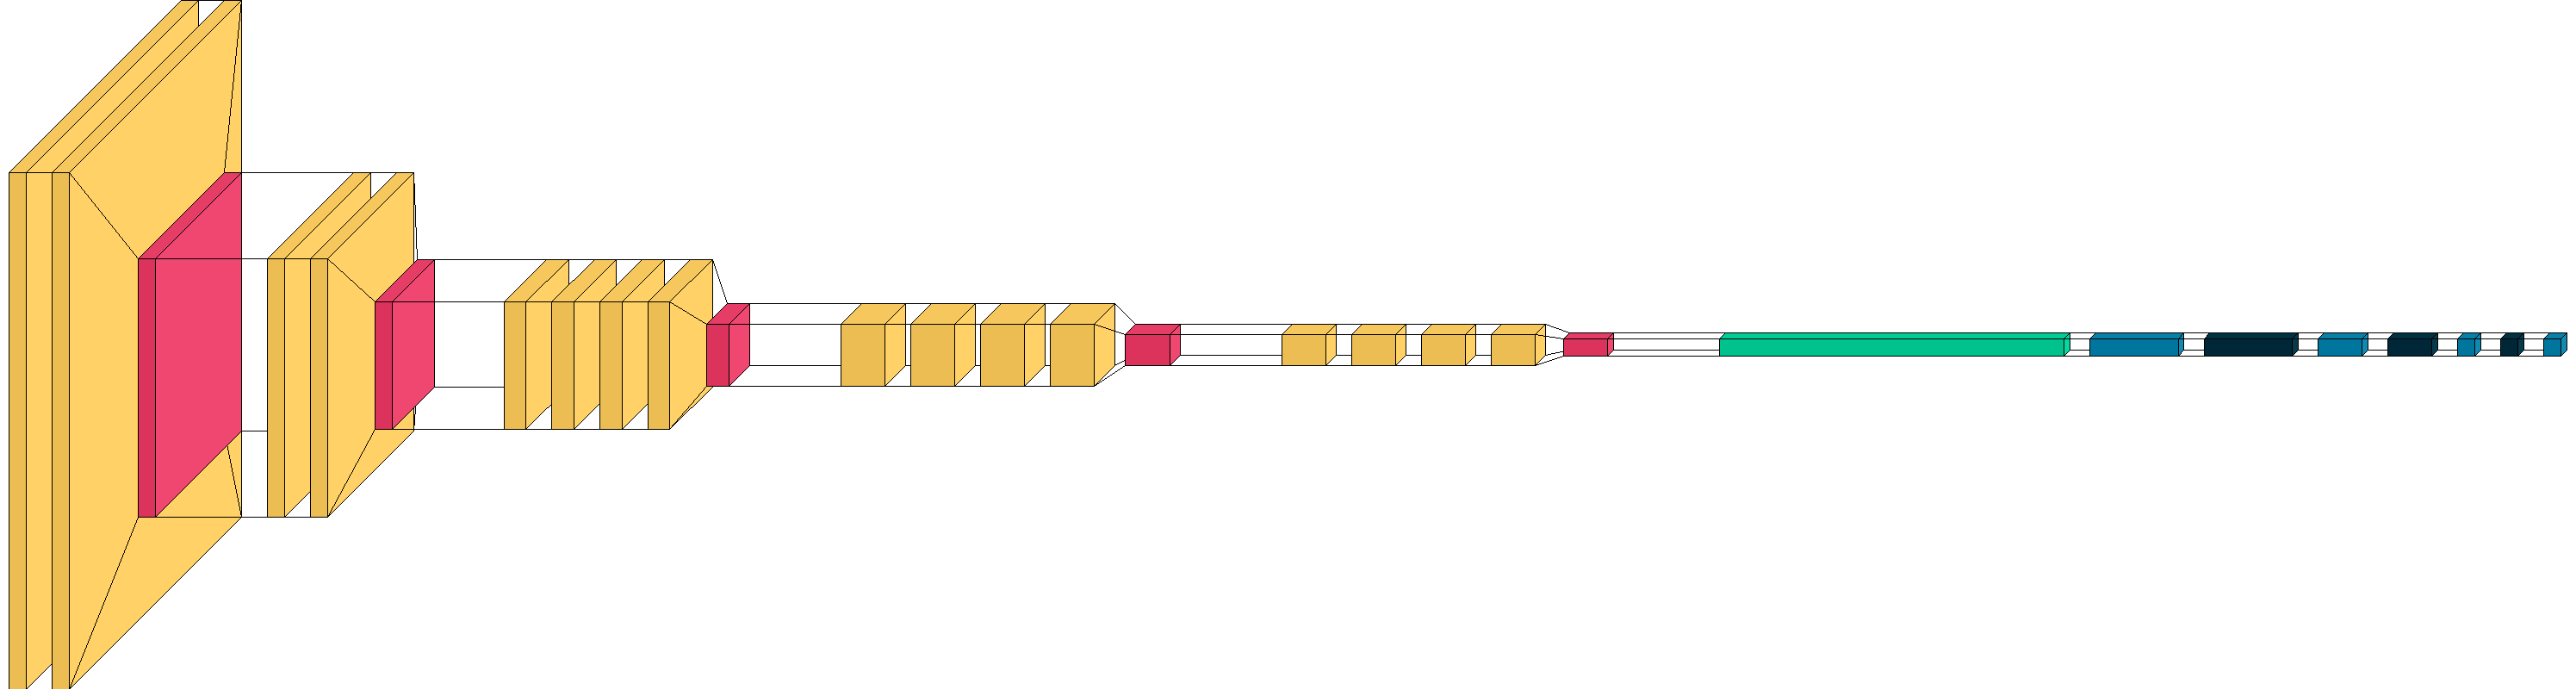

In [30]:
magic.compile(
    optimizer=SGD(lr=1e-4, momentum=0.9, nesterov=True),
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=['accuracy'])
print(magic.summary())
vk.layered_view(magic, spacing=30)

In [31]:
class AccuracyStopping(keras.callbacks.Callback):
    def __init__(self, acc_threshold, verbose=1):
        super(AccuracyStopping, self).__init__()
        self._acc_threshold = acc_threshold
        self.verbose = verbose

    def on_epoch_end(self, epoch, logs={}):
        train_acc = logs.get('accuracy') != None and logs.get('accuracy')
        if self.verbose > 0: print(f'Training Accuracy Threshold: {train_acc} / {self._acc_threshold}')
        self.model.stop_training = train_acc >= self._acc_threshold
acc_callback = AccuracyStopping(accuracy_threshold, verbose=0)
pbar = TqdmCallback(verbose=1,tqdm_class=tqdm_notebook, leave = True, display = False)
pbar.epoch_bar.ncols=0
plot = PlotLossesKeras()

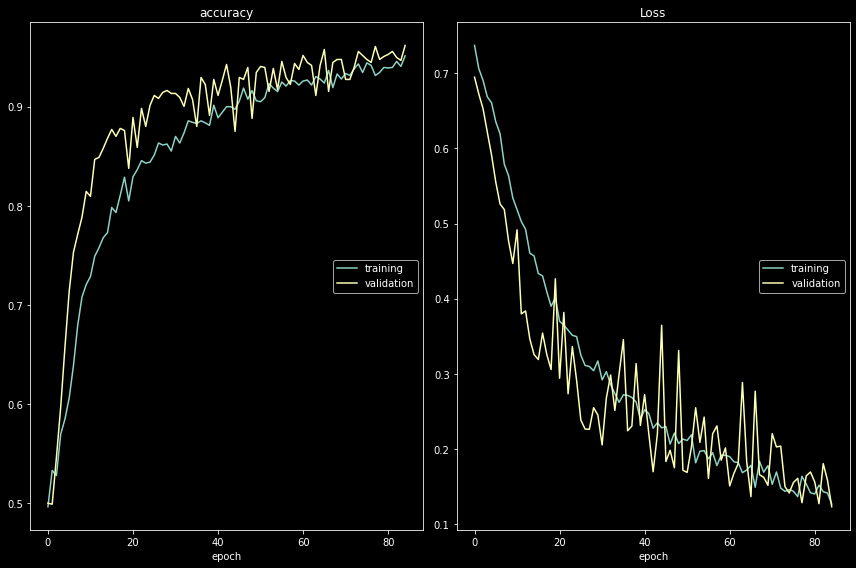

accuracy
	training         	 (min:    0.496, max:    0.951, cur:    0.951)
	validation       	 (min:    0.499, max:    0.962, cur:    0.962)
Loss
	training         	 (min:    0.126, max:    0.737, cur:    0.126)
	validation       	 (min:    0.123, max:    0.695, cur:    0.123)
Wall time: 31min 36s


In [32]:
%%time
pbar.display()
history = magic.fit(
    train_data_gen,
    steps_per_epoch=total_train // batch_size,
    epochs=epochs,
    verbose=0,
    validation_data=val_data_gen,
    validation_steps=total_val // batch_size,
    callbacks=[pbar,plot,acc_callback]
)

![](https://github.com/DMinghao/Deep_Learning_with_Unstructured_Data/blob/main/Labs/Lab_5/cute_kitten.jpg?raw=true)

In [33]:
magic.save_weights('weights.h5')

### Reference

https://cs231n.github.io/